In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn import metrics
from torch.cuda.amp import autocast
from tqdm import tqdm

from distillistic import ImageNet_loader, set_seed, resnet18, accuracy

In [2]:
data_path = "../data/imagenet"
batch_size = 160
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
workers = 12

g = set_seed(42)

# train_loader = ImageNet_loader(data_path, batch_size, device,
#     train=True, generator=g, workers=workers, use_amp=torch.cuda.is_available(), use_ffcv=False)
test_loader = ImageNet_loader(data_path, batch_size, device,
    train=False, generator=g, workers=workers, use_amp=cuda, use_ffcv=False)

Load data with FFCV is set to False.


In [3]:
algo = "tfkd"
load_dir = f"./experiments/imagenet/session2/{algo}000/"

model = resnet18(1000, pretrained=False).to(device)

In [4]:
if algo == "dml":
    model_pt = glob.glob(os.path.join(load_dir, "student*.pt"))[0]
    state_dict = torch.load(model_pt, map_location=device)
    model.load_state_dict(state_dict)
else:
    state_dict = torch.load(os.path.join(load_dir, "student.pt"), map_location=device)
    model.load_state_dict(state_dict)

In [5]:
model.eval()
outputs = []
targets = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):

        data = data.to(device)
        target = target.to(device)
        
        with autocast(enabled=False):
            output = model(data)
        
        if isinstance(output, tuple):
            output = output[0]
        
        outputs.append(output)
        targets.append(target)

100%|██████████| 313/313 [11:50<00:00,  2.27s/it]


In [6]:
out_tensor = torch.cat(outputs, dim=0)
target_tensor = torch.cat(targets, dim=0)

In [7]:
one_hot = F.one_hot(target_tensor, num_classes=1000)
out_prob = F.softmax(out_tensor, dim=-1)
one_hot.shape, out_prob.shape

(torch.Size([50000, 1000]), torch.Size([50000, 1000]))

In [8]:
auc = metrics.roc_auc_score(one_hot.cpu(), out_prob.cpu(), multi_class="ovr")

In [9]:
auc

0.9956086692692693

In [13]:
metrics.roc_auc_score(one_hot.cpu(), out_prob.cpu(), multi_class="ovr", average="micro")

0.9961937306868854

In [10]:
top1, top5 = accuracy(out_prob, target_tensor, topk=(1,5))
top1.item(), top5.item()

(0.6615999937057495, 0.8666799664497375)

In [11]:
print(metrics.classification_report(target_tensor.cpu(), out_prob.argmax(dim=-1, keepdim=True).cpu()))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91        50
           1       0.84      0.76      0.80        50
           2       0.83      0.70      0.76        50
           3       0.73      0.76      0.75        50
           4       0.76      0.74      0.75        50
           5       0.82      0.72      0.77        50
           6       0.61      0.74      0.67        50
           7       0.92      0.66      0.77        50
           8       0.80      0.86      0.83        50
           9       0.87      0.94      0.90        50
          10       0.84      0.82      0.83        50
          11       0.90      0.92      0.91        50
          12       0.88      0.86      0.87        50
          13       0.91      0.96      0.93        50
          14       0.82      0.84      0.83        50
          15       0.96      0.90      0.93        50
          16       0.87      0.90      0.88        50
          17       0.89    

In [12]:
metrics.f1_score(target_tensor.cpu(), out_prob.argmax(dim=-1, keepdim=True).cpu(), average="macro")

0.6565446491790744

### I tried out a new library

In [ ]:
import scikitplot as skplt

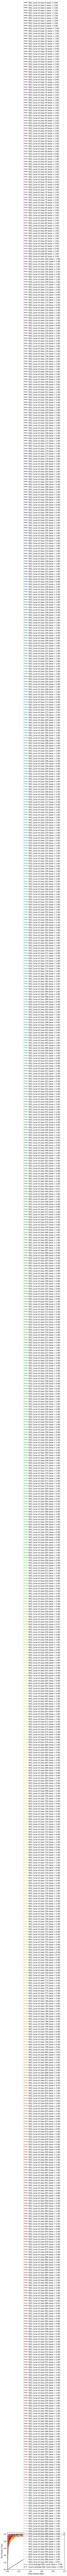

In [14]:
# metrics.RocCurveDisplay.from_predictions(one_hot.cpu(), out_prob.cpu())
skplt.metrics.plot_roc(target_tensor.cpu(), out_prob.cpu())

plt.show()

KeyboardInterrupt: 

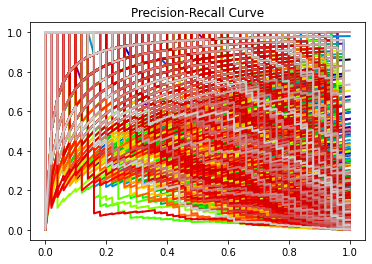

In [16]:
skplt.metrics.plot_precision_recall(target_tensor.cpu(), out_prob.cpu())

plt.show()